In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
from tensorflow import keras
from keras.models import Model
from keras.losses import MSE
from keras.layers import ReLU, Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate
from keras.applications.vgg19 import VGG19, preprocess_input
import subprocess

In [28]:
# Check TF versions and CPU/GPU availability
print(tf.__version__)
print(tf.config.list_physical_devices())
print(tf.test.is_gpu_available)
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

command = "nvcc --version"
result = subprocess.run(command, stdout=subprocess.PIPE, shell=True, text=True)
print(result.stdout)
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.compat.v1.enable_eager_execution()


2.10.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_gpu_available at 0x0000024336EBCCA0>
True
True
Num CPUs Available:  1
Num GPUs Available:  1
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


## 1. Input Dimensions

In [29]:
num_im = 50      # Number of examples in dataset
frames = 9       # Number of sub-frames per example
im_dim = 480     # Image dimension (after super-res)
cropsize = 128    # Crop size for training
bg_lvl = 0       # Optional bg level subtraction

In [30]:
input_frames = np.zeros([num_im,cropsize,cropsize,frames])
gt_frames = np.zeros([num_im,cropsize,cropsize,1])
lr_frames = np.zeros([num_im,cropsize,cropsize,1])
patterns = np.zeros([frames,cropsize,cropsize,1])

## 2. Load Data

In [31]:
data_name = 'microtubules'
dir_name = 'Data/SIM/'

center_x = (im_dim - cropsize) // 2
center_y = (im_dim - cropsize) // 2

for i in range(1,num_im):
      
    for j in range(1,(frames+1)):
       
        input_path = dir_name+data_name+'/input_frames/'+str(i)+'_'+str(j)+'.png'
        input_temp = cv2.imread(input_path,0)
        input_temp = cv2.resize(input_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
        input_temp = input_temp[center_y:center_y+cropsize, center_x:center_x+cropsize]
        input_frames[i-1,:,:,j-1] = input_temp                  
    
    gt_path = dir_name+data_name+'/ground_truth/'+str(i)+'.png'
    gt_temp = cv2.imread(gt_path,0)
    gt_temp = cv2.resize(gt_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    gt_temp = gt_temp.reshape([im_dim,im_dim,1])
    gt_temp = gt_temp[center_y:center_y+cropsize, center_x:center_x+cropsize]
    gt_frames[i-1,:,:,:] = gt_temp

    lr_path = dir_name+data_name+'/low_res/'+str(i)+'.png'
    lr_temp = cv2.imread(lr_path,0)
    lr_temp = cv2.resize(lr_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    lr_temp = lr_temp.reshape([im_dim,im_dim,1])
    lr_temp = lr_temp[center_y:center_y+cropsize, center_x:center_x+cropsize]
    lr_frames[i-1,:,:,:] = lr_temp
    

for i in range(1,(frames+1)):
    
    pattern_path = dir_name+data_name+'/patterns/'+str(i)+'.png'
    pattern_temp = cv2.imread(pattern_path,0)
    pattern = cv2.resize(pattern_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)  
    pattern = pattern.reshape([im_dim,im_dim,1])
    pattern = pattern[center_y:center_y+cropsize, center_x:center_x+cropsize]
    patterns[i-1,:,:,:] = pattern
    

## 3. Check and Normalize Data

In [32]:

print(np.amax(input_frames))
input_frames = input_frames - bg_lvl
input_frames[input_frames<0] = 0
input_frames = input_frames/np.amax(input_frames)
print(np.amax(input_frames))
gt_frames = gt_frames/np.amax(gt_frames)
lr_frames = lr_frames/np.amax(lr_frames)
patterns = patterns/np.amax(patterns)
print(input_frames.shape)
print(gt_frames.shape)

255.0
1.0
(50, 128, 128, 9)
(50, 128, 128, 1)


Text(0.5, 1.0, 'Illumination pattern')

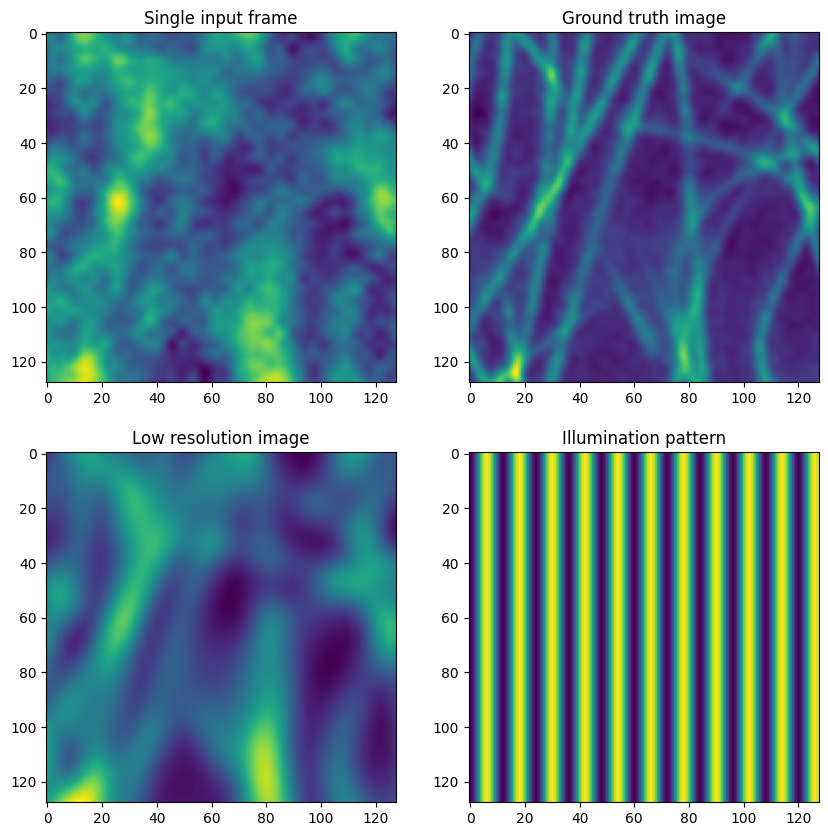

In [33]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(input_frames[0,:,:,1])
plt.title('Single input frame')
plt.subplot(2,2,2)
plt.imshow(gt_frames[0,:,:,:])
plt.title('Ground truth image')
plt.subplot(2,2,3)
plt.imshow(lr_frames[0,:,:,:])
plt.title('Low resolution image')
plt.subplot(2,2,4)
plt.imshow(patterns[0,:,:,:])
plt.title('Illumination pattern')

## 4. Define PSF

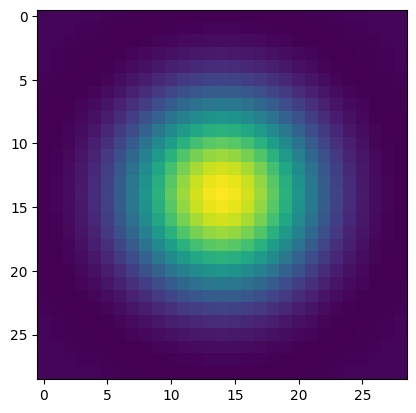

In [34]:
psf = cv2.imread(dir_name+data_name+'/psf.png',0)
plt.imshow(psf)
psf = np.reshape(psf,[np.ma.size(psf,0),np.ma.size(psf,0),1,1])

## 5. Define Network

In [35]:
k_size = 3

def u_net():
    
    inputs = Input((cropsize,cropsize,frames))
    block1 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(inputs)
    block2 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block1)
    block2 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block2)
    
    down1 = MaxPooling2D(pool_size=(2,2))(block2)
    block3 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(down1)
    block3 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(block3)
    
    down2 = MaxPooling2D(pool_size=(2,2))(block3)
    block4 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(down2)
    block4 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(block4)
    
    down3 = MaxPooling2D(pool_size=(2,2))(block4)
    block5 = Conv2D(256, (k_size, k_size), padding="same", activation = 'relu')(down3)
    block5 = Conv2D(256, (k_size, k_size), padding="same", activation = 'relu')(block5)
    
    up1 = UpSampling2D(size=(2,2))(block5)
    cat1 = concatenate([block4,up1])
    block6 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(cat1)
    block6 = Conv2D(128, (k_size, k_size), padding="same", activation = 'relu')(block6)
    
    up2 = UpSampling2D(size=(2,2))(block6)
    cat2 = concatenate([block3,up2])
    block7 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(cat2)
    block7 = Conv2D(64, (k_size, k_size), padding="same", activation = 'relu')(block7)
    
    up3 = UpSampling2D(size=(2,2))(block7)
    cat3 = concatenate([block2,up3])
    block8 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(cat3)
    block8 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block8)
    
    block9 = Conv2D(32, (k_size, k_size), padding="same", activation = 'relu')(block8)
    output = Conv2D(1, (1, 1), padding="same")(block9)
    #output = tf.keras.layers.ReLU(max_value=1.0)(output)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[output])
    
    return model

In [36]:
model = u_net()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 9  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 128, 128, 32  2624        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_34[0][0]']              
                                )                                                           

## 6. Define Forward Model Loss Function

In [37]:
# SSIM_loss
def SSIM_Loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def FFT_trans(x,eps):
    x=tf.complex(x,tf.zeros_like(x))
    vF=tf.signal.fft2d(x)
    vF=tf.signal.fftshift(vF)
    vF_real=tf.math.real(vF)
    vF_imag=tf.math.imag(vF)
    vF=tf.stack([vF_real,vF_imag],axis=-1)
    out_amp=tf.sqrt(tf.add(tf.square(vF_real),tf.square(vF_imag))+eps)
    out_phase=tf.atan2(vF_real,vF_imag+eps)
    return out_amp,out_phase

def FFT_loss(y_true,y_pred):
    eps=1e-7
    #_assert_no_grad(y_true)
    real_fft_amp,real_fft_pha=FFT_trans(y_true,eps)
    fake_fft_amp,fake_fft_pha=FFT_trans(y_pred,eps)
    amp_dis=tf.subtract(real_fft_amp,fake_fft_amp)
    pha_dis=tf.subtract(real_fft_pha,fake_fft_pha)
    fft_dis=tf.sqrt(tf.add(tf.square(amp_dis),tf.square(pha_dis))+eps)
    fft_loss=tf.reduce_mean(fft_dis)
    return fft_loss

# perceptual loss from a pretrained VGG19 network
# input_shape=(480,480,3)
def perceptual_loss(y_true,y_pred):
    loss=0
    for i in range(y_pred.shape[0]):
        pred_channel = y_pred[i,...]
        true_channel = y_true[i,...]
        
        # print("pred_channel:",pred_channel.shape)
        # print("true_channel:",true_channel.shape)

        # Convert to RGB format (assuming 1 channel input)
        rgb_pred = tf.image.grayscale_to_rgb(pred_channel)
        rgb_true = tf.image.grayscale_to_rgb(true_channel)
        
        rgb_pred=tf.squeeze(rgb_pred)
        rgb_true=tf.squeeze(rgb_true)
        # Preprocess for VGG19
        rgb_pred = preprocess_input(rgb_pred)
        rgb_true = preprocess_input(rgb_true)

        # Expand dimensions to match VGG19 input shape
        rgb_pred = tf.expand_dims(rgb_pred, axis=0)
        rgb_true = tf.expand_dims(rgb_true, axis=0)
        
        # print("rgb_pred:",rgb_pred.shape)
        # print("rgb_true:",rgb_true.shape)
        # Get VGG19 features
        features_pred = vgg_model(rgb_pred)
        features_true = vgg_model(rgb_true)
        loss += tf.math.reduce_mean(MSE(features_pred, features_true))
    #print("pl loss:",loss)
    return loss

# loss based on OS-SIM
def generate_direct_high_res_image(y_stack):
    alpha=0.80
    high_res_image=1
    return high_res_image

In [38]:
def Physics_Loss(y_true, y_pred):
    
    loss = 0
    y_pred = tf.transpose(y_pred,(3,1,2,0))
    y_true = tf.transpose(y_true,(3,1,2,0))
    
    for i in range(0,(batch_size)):
        
        pred = y_pred[:,:,:,i-1]
        pred = tf.expand_dims(pred,3)
        # multiply predicted object by illumination patterns
        prod = tf.math.multiply(pred,patterns)
        # convolve with PSF
        conv = tf.nn.conv2d(prod,psf,strides=[1,1,1,1],padding='SAME',data_format='NHWC')    
        conv = tf.math.divide(tf.math.subtract(conv,tf.reduce_min(conv)),tf.math.subtract(tf.reduce_max(conv),tf.reduce_min(conv)))
       
        true = y_true[:,:,:,i-1]
        true = tf.expand_dims(true,3)
        pl_flag=1
        pl_loss=0
        im_loss = SSIM_Loss(conv,true)
        if pl_flag:
            pl_loss=perceptual_loss(conv,true)  
            loss = loss + 0.5*pl_loss + 0.5*im_loss
        else:
            loss = loss + im_loss
        print("im_loss",im_loss)
        print("pl_loss",pl_loss)
            
    return loss

## 8. Run Network Optimization

In [39]:
ind = 23
single_input = input_frames[ind-1,:,:,:]
single_input = single_input.reshape([1,cropsize,cropsize,frames])
print(single_input.shape)

(1, 128, 128, 9)


In [40]:
learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=50,
    decay_rate=0.90,
    staircase=True)

opt = tf.keras.optimizers.Adam(lr_schedule)
batch_size = 1
eps = 100
l = Physics_Loss

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr

lr_metric=get_lr_metric(opt)
input_shape=(cropsize,cropsize,3)
vgg=VGG19(include_top=False,weights='imagenet',input_shape=input_shape)
vgg.trainable = False
vgg_model=Model(inputs=vgg.input,outputs=vgg.get_layer('block5_conv4').output)

model.compile(loss=l, optimizer=opt,metrics=['accuracy',lr_metric],run_eagerly=True)
model_history = model.fit(x=single_input,y=single_input,epochs=eps,batch_size=batch_size)

Epoch 1/100
im_loss tf.Tensor(0.6275393, shape=(), dtype=float32)
pl_loss tf.Tensor(0.0007464072, shape=(), dtype=float32)
1/1 [==============================] - 2s 2s/step - loss: 0.3141 - accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
im_loss tf.Tensor(0.21634579, shape=(), dtype=float32)
pl_loss tf.Tensor(0.0006005662, shape=(), dtype=float32)
1/1 [==============================] - 1s 1s/step - loss: 0.1085 - accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
im_loss tf.Tensor(0.41625804, shape=(), dtype=float32)
pl_loss tf.Tensor(0.0013699497, shape=(), dtype=float32)
1/1 [==============================] - 1s 1s/step - loss: 0.2088 - accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
im_loss tf.Tensor(0.30343044, shape=(), dtype=float32)
pl_loss tf.Tensor(0.0008695339, shape=(), dtype=float32)
1/1 [==============================] - 1s 1s/step - loss: 0.1521 - accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
im_loss tf.Tensor(0.23298466, shape=(), dtype=float32)
pl_loss tf.Tensor(0.0007339207, sh

KeyboardInterrupt: 

In [ ]:
plt.plot(np.linspace(1,eps,num=eps),model_history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Optimization Loss')
plt.subplots_adjust(wspace = 0.5)

## 8. Plot PINN Results

In [ ]:
predicted = model.predict(single_input)

print(predicted.shape)
predicted = predicted.reshape([cropsize,cropsize])
#predicted = predicted[20:(cropsize-20),20:(cropsize-20)]
predicted = (predicted-np.amin(predicted))/(np.amax(predicted)-np.amin(predicted))

gt = gt_frames[ind-1,:,:,:]
#gt = gt[20:(cropsize-20),20:(cropsize-20)]
gt = (gt-np.amin(gt))/(np.amax(gt)-np.amin(gt))
#gt = gt.reshape([(cropsize-40),(cropsize-40)])

lowres = lr_frames[ind-1,:,:,:]
#lowres = lowres[20:(cropsize-20),20:(cropsize-20)]
lowres = (lowres-np.amin(lowres))/(np.amax(lowres)-np.amin(lowres))
#lowres = lowres.reshape([(cropsize-40),(cropsize-40)])

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(gt,cmap='inferno')
plt.title('Ground truth image')
plt.subplot(1,3,2)
plt.imshow(predicted,cmap='inferno')
plt.title('PINN Result')
plt.subplot(1,3,3)
plt.imshow(lowres,cmap='inferno')
plt.title('Diffraction limited image')